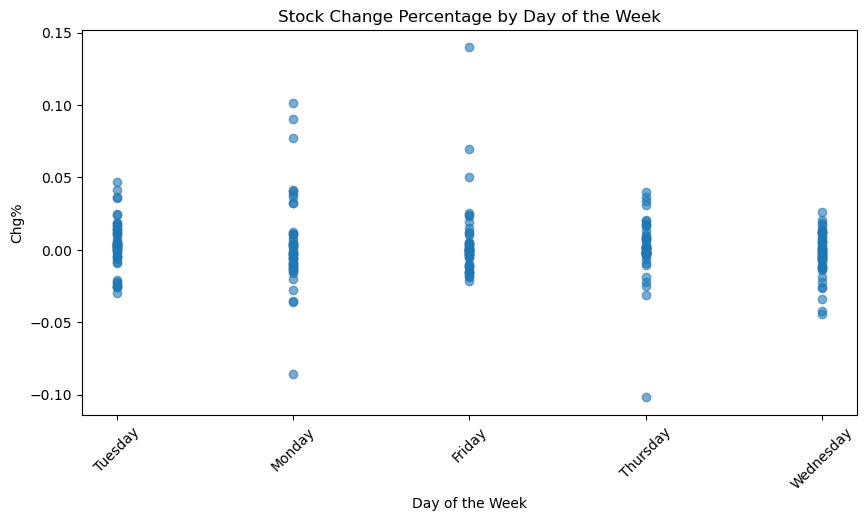

Dimensionality of vector space: 3
Number of vectors: 10
Rank of matrix A: 3
Cost of each product (Candy, Mango, Milk): [ 1. 55. 18.]
Model vector X (for predicting product costs): [ 1. 55. 18.]
Customer Classification:
  Category
0     RICH
1     RICH
2     RICH
3     POOR
4     RICH
5     POOR
6     RICH
7     RICH
8     POOR
9     POOR
Mean stock price: 1560.663453815261
Variance in stock price: 58732.365352539186
Mean price on Wednesdays: 1550.706
Mean price in April: 1698.9526315789474
Probability of making a loss: 0.4979919678714859
Probability of making a profit on Wednesday: 0.42
Conditional probability of profit given Wednesday: 0.8433870967741935
Thyroid Data Types:
Record ID                    float64
age                          float64
sex                           object
on thyroxine                  object
query on thyroxine            object
on antithyroid medication     object
sick                          object
pregnant                      object
thyroid surgery     

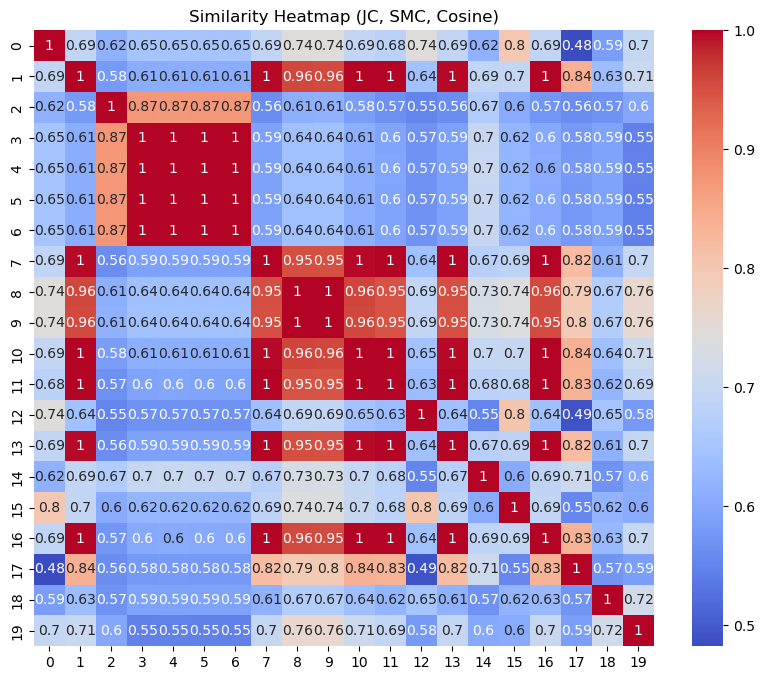

In [13]:
import pandas as pd
import numpy as np
import statistics
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
import seaborn as sns

def load_data(file_path, sheet_name):
    return pd.read_excel(file_path, sheet_name=sheet_name)

def extract_matrices(data):
    A = data.iloc[:, 1:4].to_numpy()
    C = data.iloc[:, 4].to_numpy().reshape(-1, 1)
    return A, C

def compute_matrix_properties(A):
    dimensionality = A.shape[1]
    num_vectors = A.shape[0]
    rank_A = np.linalg.matrix_rank(A)
    return dimensionality, num_vectors, rank_A

def compute_product_costs(A, C):
    A_pseudo_inv = np.linalg.pinv(A)
    product_costs = A_pseudo_inv @ C
    return product_costs.flatten()

def compute_model_vector(A, C):
    A_pseudo_inv = np.linalg.pinv(A)
    X = A_pseudo_inv @ C
    return X.flatten()

def classify_customers(data):
    data["Category"] = np.where(data.iloc[:, 4] > 200, "RICH", "POOR")
    return data[["Category"]]

def analyze_stock_prices(data):
    price_data = data.iloc[:, 3] 
    chg_percent = data.iloc[:, 8]  
    data["Day"] = pd.to_datetime(data.iloc[:, 0]).dt.day_name()
    
    mean_price = statistics.mean(price_data)
    variance_price = statistics.variance(price_data)
    
    wednesday_prices = price_data[data["Day"] == "Wednesday"]
    mean_wednesday = statistics.mean(wednesday_prices)
    
    april_prices = price_data[pd.to_datetime(data.iloc[:, 0]).dt.month == 4]
    mean_april = statistics.mean(april_prices)
    
    loss_probability = sum(chg_percent < 0) / len(chg_percent)
    profit_wednesday = sum((chg_percent > 0) & (data["Day"] == "Wednesday")) / sum(data["Day"] == "Wednesday")
    conditional_profit = profit_wednesday / loss_probability if loss_probability > 0 else 0
    
    # Scatter plot of Chg% against day of the week
    plt.figure(figsize=(10, 5))
    plt.scatter(data["Day"], chg_percent, alpha=0.6)
    plt.xlabel("Day of the Week")
    plt.ylabel("Chg%")
    plt.title("Stock Change Percentage by Day of the Week")
    plt.xticks(rotation=45)
    plt.show()
    
    return mean_price, variance_price, mean_wednesday, mean_april, loss_probability, profit_wednesday, conditional_profit

def explore_thyroid_data(data):
    data_types = data.dtypes
    missing_values = data.isnull().sum()
    
    categorical_columns = data.select_dtypes(include=['object']).columns.tolist()
    numerical_columns = data.select_dtypes(include=['number']).columns.tolist()
    
    for col in data.columns:
        data[col] = pd.to_numeric(data[col], errors='ignore')
    
    label_encoders = {}
    for col in categorical_columns:
        if data[col].dtype == 'object':  
            le = LabelEncoder()
            data[col] = le.fit_transform(data[col].astype(str))
            label_encoders[col] = le
    
    outliers = {}
    for col in numerical_columns:
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        outliers[col] = ((data[col] < (Q1 - 1.5 * IQR)) | (data[col] > (Q3 + 1.5 * IQR))).sum()
    
    numerical_summary = {col: {'Mean': data[col].mean(), 'Variance': data[col].var()} for col in numerical_columns}
    
    for col in numerical_columns:
        if outliers[col] > 0:
            data[col].fillna(data[col].median(), inplace=True)
        else:
            data[col].fillna(data[col].mean(), inplace=True)
    
    for col in categorical_columns:
        data[col].fillna(data[col].mode()[0], inplace=True)
        
    return data_types, missing_values, outliers, numerical_summary

def normalize_data(data):
    numerical_columns = data.select_dtypes(include=['number']).columns.tolist()
    scaler = MinMaxScaler()
    data[numerical_columns] = scaler.fit_transform(data[numerical_columns])
    return data

def compute_similarity(data):
    binary_data = data.select_dtypes(include=['int', 'bool']).iloc[:2]  # Select first two binary vectors
    f11 = np.sum((binary_data.iloc[0] == 1) & (binary_data.iloc[1] == 1))
    f00 = np.sum((binary_data.iloc[0] == 0) & (binary_data.iloc[1] == 0))
    f10 = np.sum((binary_data.iloc[0] == 1) & (binary_data.iloc[1] == 0))
    f01 = np.sum((binary_data.iloc[0] == 0) & (binary_data.iloc[1] == 1))
    
    jc = f11 / (f01 + f10 + f11)
    smc = (f11 + f00) / (f00 + f01 + f10 + f11)
    
    return jc, smc

def compute_cosine_similarity(data):
    vectors = data.iloc[:2].to_numpy()
    dot_product = np.dot(vectors[0], vectors[1])
    norm_a = np.linalg.norm(vectors[0])
    norm_b = np.linalg.norm(vectors[1])
    similarity = dot_product / (norm_a * norm_b)
    return similarity

def plot_heatmap(data):
    similarity_matrix = np.zeros((20, 20))
    
    for i in range(20):
        for j in range(20):
            vec_i = data.iloc[i]
            vec_j = data.iloc[j]
            f11 = np.sum((vec_i == 1) & (vec_j == 1))
            f00 = np.sum((vec_i == 0) & (vec_j == 0))
            f10 = np.sum((vec_i == 1) & (vec_j == 0))
            f01 = np.sum((vec_i == 0) & (vec_j == 1))
            
            jc = f11 / (f01 + f10 + f11) if (f01 + f10 + f11) != 0 else 0
            smc = (f11 + f00) / (f00 + f01 + f10 + f11)
            cosine_sim = np.dot(vec_i, vec_j) / (np.linalg.norm(vec_i) * np.linalg.norm(vec_j))
            
            similarity_matrix[i, j] = (jc + smc + cosine_sim) / 3
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(similarity_matrix, annot=True, cmap='coolwarm')
    plt.title("Similarity Heatmap (JC, SMC, Cosine)")
    plt.show()
    
def main():
    file_path = "C:\\Users\\yasaswini ginjupalli\\Downloads\\Lab Session Data.xlsx"
    purchase_data = load_data(file_path, "Purchase data")
    stock_data = load_data(file_path, "IRCTC Stock Price")
    thyroid_data = load_data(file_path, "thyroid0387_UCI")
    thyroid_data_normalized = normalize_data(thyroid_data)
    
    A, C = extract_matrices(purchase_data)
    
    dimensionality, num_vectors, rank_A = compute_matrix_properties(A)
    model_vector_X = compute_model_vector(A, C)
    product_costs = compute_product_costs(A, C)
    
    customer_classes = classify_customers(purchase_data)
    
    mean_price, variance_price, mean_wednesday, mean_april, loss_probability, profit_wednesday, conditional_profit = analyze_stock_prices(stock_data)
    
    data_types, missing_values, outliers, numerical_summary = explore_thyroid_data(thyroid_data)
    
    jc, smc = compute_similarity(thyroid_data_normalized)
    cosine_sim = compute_cosine_similarity(thyroid_data_normalized)
    
    print(f"Dimensionality of vector space: {dimensionality}")
    print(f"Number of vectors: {num_vectors}")
    print(f"Rank of matrix A: {rank_A}")
    print(f"Cost of each product (Candy, Mango, Milk): {product_costs}")
    print(f"Model vector X (for predicting product costs): {model_vector_X}")
    print("Customer Classification:")
    print(customer_classes)
    print(f"Mean stock price: {mean_price}")
    print(f"Variance in stock price: {variance_price}")
    print(f"Mean price on Wednesdays: {mean_wednesday}")
    print(f"Mean price in April: {mean_april}")
    print(f"Probability of making a loss: {loss_probability}")
    print(f"Probability of making a profit on Wednesday: {profit_wednesday}")
    print(f"Conditional probability of profit given Wednesday: {conditional_profit}")
    print("Thyroid Data Types:")
    print(data_types)
    print("Missing Values:")
    print(missing_values)
    print("Outliers Count:")
    print(outliers)
    print("Numerical Summary:")
    print(numerical_summary)
    print("Normalized Thyroid Data:")
    print(thyroid_data_normalized.head())
    print("Jaccard Coefficient:", jc)
    print("Simple Matching Coefficient:", smc)
    print("Cosine Similarity:", cosine_sim)
    
    plot_heatmap(thyroid_data_normalized)


if __name__ == "__main__":
    main()
